In [1]:
import torch
import numpy as np
import pandas as pd
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch.nn as nn

from lightning_models import ForecastNextKDays_Boosted
from torchinfo import summary

In [2]:
model = ForecastNextKDays_Boosted(data_path = 'Dataset/IKCO1.csv',      
                        split = [0.80, 0.10, 0.10],
                        batch_size = 128,
                        learning_rate = 5e-4,
                        weight_decay = 0.0001)


summary(model, input_size = (128, 21, 5))

Layer (type:depth-idx)                   Output Shape              Param #
ForecastNextKDays_Boosted                --                        --
├─AELSTM: 1-1                            [128, 1]                  --
│    └─Encoder: 2-1                      [128, 21, 2]              --
│    │    └─LSTM: 3-1                    [128, 21, 3]              120
│    │    └─LSTM: 3-2                    [128, 21, 2]              56
│    └─Decoder: 2-2                      [128, 21, 5]              --
│    │    └─LSTM: 3-3                    [128, 21, 3]              84
│    │    └─LSTM: 3-4                    [128, 21, 5]              200
│    └─forecastLSTM: 2-3                 [128, 1]                  --
│    │    └─LSTM: 3-5                    [128, 21, 128]            463,872
│    │    └─Linear: 3-6                  [128, 1]                  129
├─L1Loss: 1-2                            --                        --
├─MeanAbsoluteError: 1-3                 --                        --
Total p

In [3]:
checkpoint_callback = ModelCheckpoint(dirpath = 'forecast-boosted',
                                    filename = "checkpoint.ckpt",
                                    every_n_epochs = 1,
                                    monitor = 'val_loss',
                                    mode = 'min')

early_stop_callback = EarlyStopping(monitor = "val_loss",
                                    min_delta = 0.00,
                                    patience = 30,
                                    verbose = False,
                                    mode = "min")

logger = TensorBoardLogger('forecast-boosted-logs/', name = 'forecast-boosted', version = 0)

In [4]:
trainer = Trainer(
    default_root_dir = 'forecast-boosted-logs/',
    gpus = (1 if torch.cuda.is_available() else 0),
    callbacks = [checkpoint_callback, early_stop_callback],
    max_epochs = 200,
    logger = logger)

trainer.fit(model = model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type              | Params
----------------------------------------------------------
0 | model               | AELSTM            | 464 K 
1 | loss                | L1Loss            | 0     
2 | mean_absolute_error | MeanAbsoluteError | 0     
----------------------------------------------------------
464 K     Trainable params
0         Non-trainable params
464 K     Total params
1.858     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1927: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 157:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0461, v_num=0, train_loss=0.0554]         

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [5]:
trainer.test(datamodule = model)

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1444: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:412: LightningDeprecationWarning: `LightningDataModule.on_save_checkpoint` was deprecated in v1.6 and will be removed in v1.8. Use `state_dict` instead.
  rank_zero_deprecation(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:417: LightningDeprecationWarning: `LightningDataModule.on_load_checkpoint` was deprecated in v1.6 and will be removed in v1.8. Use `load_state_dict` instead.
  rank_zero_deprecation(
Restoring states from the checkpoint path at C:\Users\Yegyanathan V\Desktop\Python\De

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 77.13it/s] =0, train_loss=0.0554]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           MAE              0.18012051284313202
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'MAE': 0.18012051284313202}]

In [49]:
from utils import create_dataset

model = model.load_from_checkpoint("forecast-boosted\checkpoint.ckpt.ckpt")
df = pd.read_csv('Dataset\FOLD1.csv', index_col = [0])

df_X = df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>','<VOL>']] 
df_y = df[['<CLOSE>']]

df_X_scaled = model.scaler_X.transform(df_X)


inputs, actuals = create_dataset(df_X_scaled, df_y, 21, 10)

In [50]:
print(inputs.shape, actuals.shape)

(2996, 21, 5) (2996, 1)


In [51]:
inputs = torch.tensor(inputs.astype(np.float32))
inputs

tensor([[[0.1121, 0.0961, 0.1179, 0.1121, 1.8720],
         [0.1121, 0.0961, 0.1221, 0.1162, 0.4001],
         [0.1162, 0.0995, 0.1196, 0.1199, 0.5050],
         ...,
         [0.1100, 0.0905, 0.1115, 0.1094, 0.0079],
         [0.1094, 0.0897, 0.1110, 0.1086, 0.0115],
         [0.1086, 0.0893, 0.1102, 0.1080, 0.0076]],

        [[0.1121, 0.0961, 0.1221, 0.1162, 0.4001],
         [0.1162, 0.0995, 0.1196, 0.1199, 0.5050],
         [0.1199, 0.0986, 0.1217, 0.1157, 0.1068],
         ...,
         [0.1094, 0.0897, 0.1110, 0.1086, 0.0115],
         [0.1086, 0.0893, 0.1102, 0.1080, 0.0076],
         [0.1080, 0.0909, 0.1096, 0.1079, 0.0055]],

        [[0.1162, 0.0995, 0.1196, 0.1199, 0.5050],
         [0.1199, 0.0986, 0.1217, 0.1157, 0.1068],
         [0.1157, 0.0951, 0.1174, 0.1119, 0.0595],
         ...,
         [0.1086, 0.0893, 0.1102, 0.1080, 0.0076],
         [0.1080, 0.0909, 0.1096, 0.1079, 0.0055],
         [0.1079, 0.0925, 0.1126, 0.1086, 0.0121]],

        ...,

        [[1.2964, 1.

In [52]:
model.eval()
with torch.no_grad():
    
    output, _ = model(inputs)

preds = output.squeeze()
preds = np.array(preds) 
preds

array([0.11273494, 0.11231129, 0.11191861, ..., 0.9129065 , 0.91264343,
       0.9142221 ], dtype=float32)

In [53]:
print(preds.shape)

(2996,)


In [54]:
predictions = pd.DataFrame(preds, columns = ['preds'])
predictions[['preds']] = model.scaler_y.inverse_transform(predictions[['preds']])

In [55]:
predictions['actuals'] = df_y['<CLOSE>']
predictions.head(10)

,preds,actuals
0,1905.915039,1900.0
1,1901.965820,1938.0
2,1898.305298,1973.0
3,1899.457275,1934.0
4,1903.099854,1898.0
5,1905.557007,1885.0
6,1375.547119,1894.0
7,952.998108,1900.0
8,772.764404,1904.0
9,817.442017,1906.0


<AxesSubplot:>

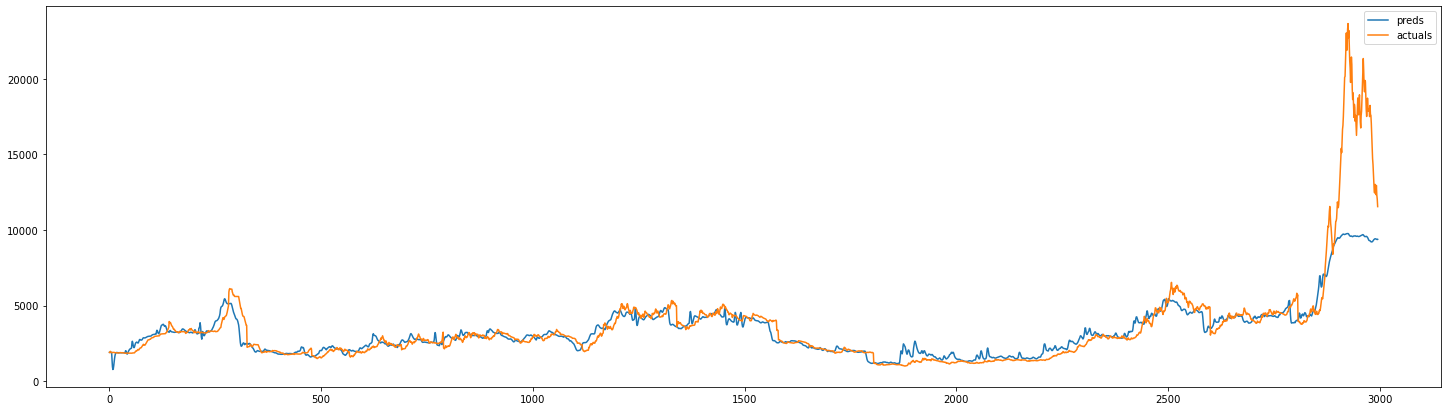

In [56]:
predictions.plot(figsize = (25, 7))